In [2]:
# Import required libraries
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set up directories for training and validation data
train_directory = r"C:\Users\Priyamvadha Pradeep\Desktop\FYP\CNN\New Models\train"
val_directory = r"C:\Users\Priyamvadha Pradeep\Desktop\FYP\CNN\New Models\validate"

# Set up ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 978 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [5]:
# Load ResNet50 pre-trained on ImageNet without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
feature_extractor = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from the training and validation sets
train_features = feature_extractor.predict(train_generator, verbose=1)
val_features = feature_extractor.predict(val_generator, verbose=1)

# Convert features and labels to numpy arrays
X_train = np.reshape(train_features, (train_features.shape[0], -1))  # Flatten the features
y_train = train_generator.classes
X_val = np.reshape(val_features, (val_features.shape[0], -1))  # Flatten the features
y_val = val_generator.classes

c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [7]:
# Normalize the extracted features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [8]:
# Define BaggingClassifier with a DecisionTreeClassifier as the base estimator
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, min_samples_split=3, min_samples_leaf=1),
    n_estimators=200,
    max_samples=0.9,
    max_features=0.9,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train the Bagging model
bagging_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = bagging_model.predict(X_val)

In [9]:
# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=train_generator.class_indices)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.6382
Confusion Matrix:
[[146  18]
 [ 71  11]]
Classification Report:
              precision    recall  f1-score   support

         als       0.67      0.89      0.77       164
     healthy       0.38      0.13      0.20        82

    accuracy                           0.64       246
   macro avg       0.53      0.51      0.48       246
weighted avg       0.57      0.64      0.58       246



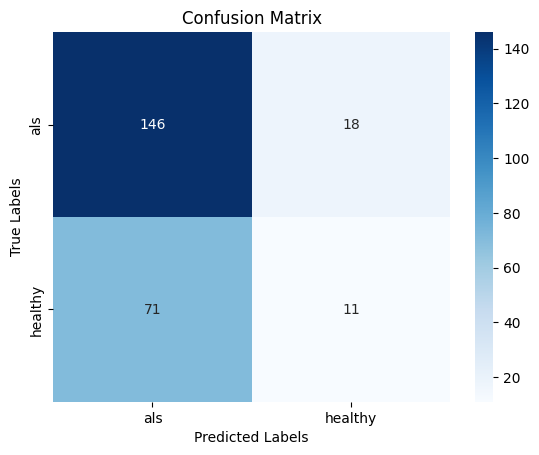

In [10]:
# Visualize confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

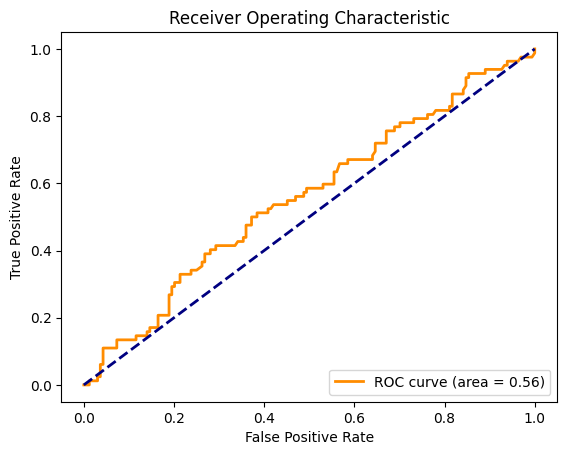

In [11]:
# Plot ROC curve
y_pred_prob = bagging_model.predict_proba(X_val)[:, 1]  # Get probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [12]:
# Feature importance visualization (if the base estimator supports it)
try:
    feature_importances = bagging_model.estimator_.feature_importances_
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.title("Feature Importance")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance Score")
    plt.show()
except AttributeError:
    print("Feature importance is not supported for the base estimator.")

Feature importance is not supported for the base estimator.
